## Evaluate Model 

In [1]:
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
import pandas as pd
import numpy as np
import os 

/home/chuang/.conda/envs/sbert/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [36]:
MODEL_OUTPUT = '/data/chuang/Language_Model_Training_Data/Models/Topic_Models/step_10000'
TOPIC_MODEL_PATH = os.path.join(MODEL_OUTPUT,'topic_model_v3')
SBERT_CHECKPOINT = '/data/chuang/Language_Model_Training_Data/Models/Saved_SBERT/10000'
emb_path = os.path.join(MODEL_OUTPUT,'sentence_embeddings.npy')
docs_path = os.path.join(MODEL_OUTPUT,'docs.npy')
topics_path = os.path.join(MODEL_OUTPUT,'topics.npy')
probabiliteis_path = os.path.join(MODEL_OUTPUT,'probabilities.npy')

OUT_TOPIC_EVAL = '/data/chuang/Language_Model_Training_Data/Models/Topic_Models/step_10000/topic_stats_v3.xlsx'

In [37]:
embeddings = np.load(emb_path)
docs = np.load(docs_path)
probs = np.load(probabiliteis_path)
topics = np.load(topics_path)
assert len(docs)==len(embeddings) == len(probs) == len(topics)

print('Number of docs: {}'.format(len(docs)))

Number of docs: 613206


In [71]:
## if trained without embedding modle, manually load embedding model here
#sentence_model = SentenceTransformer(SBERT_CHECKPOINT)          
topic_model = BERTopic.load(TOPIC_MODEL_PATH) #,embedding_model=sentence_model
topic_model.calculate_probabilities = True

In [72]:
t,p = topic_model.transform(docs[:10])
print(p[0].size)

Batches: 100%|██████████| 1/1 [00:01<00:00,  1.76s/it]


199


In [73]:
t

[-1, -1, -1, 21, 9, 5, 12, 13, -1, 119]

In [74]:
np.array(p[0]).sum()

0.8916171439384016

In [78]:
for i in range(10):
    idx = np.array(p[i]).argmax()
    print(sum(p[i]),p[i][idx])

0.8916171439384009 0.8916171439315445
0.9858217440518493 0.06059022452046887
0.6936899674769755 0.6492001796890551
0.9999999997731388 0.9999999997731388
0.9416913752191195 0.8680446222364488
0.9218780289682876 0.9069432343782784
0.9999999997456789 0.09870722032066719
0.9999999996525348 0.7225360128092632
0.9011369337973409 0.3593496840526716
0.9999999996191103 0.9999999996191073


In [39]:
topic_model.get_topic_freq()

Topic   Count
0       -1  326605
1        0   27296
2        1   11723
3        2    9748
4        3    8826
..     ...     ...
195    194      45
196    195      45
197    196      44
198    197      42
199    198      42

[200 rows x 2 columns]

In [40]:
topic_model.visualize_topics()

In [57]:
def get_eval_stats(topic_model,n_samples=10):
    topic_df = topic_model.get_topic_info()
    topic_df['topic_words'] = topic_model.generate_topic_labels(nr_words=10,
                                                            topic_prefix=False,
                                                            word_length=10,
                                                            separator=", ")
    ## get top n examples 
    n_topics = len(topic_df)
    examples = [(-1,[])]
    for t in range(n_topics-1):
        examples.append((t,topic_model.get_representative_docs(t)[:n_samples]))
    samples_df = pd.DataFrame(examples,columns=['Topic','Samples'])
    ## merge and explode
    topic_df = topic_df.merge(samples_df,how='left',on='Topic')
    topic_df = topic_df.explode('Samples')
    return topic_df

In [58]:
res_df = get_eval_stats(topic_model)
res_df.to_excel(OUT_TOPIC_EVAL,index=False)
res_df.head()

Topic   Count                                            Name  \
0     -1  326605                    -1_percent_fiscal_growth_gdp   
1      0   27296  0_washington_working paper_paper_monetary fund   
1      0   27296  0_washington_working paper_paper_monetary fund   
1      0   27296  0_washington_working paper_paper_monetary fund   
2      1   11723             1_exchange_exchange rate_rate_money   

                                         topic_words  \
0           percent, fiscal, growth, gdp, authoritie   
1  washington, working pa, paper, monetary f, int...   
1  washington, working pa, paper, monetary f, int...   
1  washington, working pa, paper, monetary f, int...   
2      exchange, exchange r, rate, money, foreign ex   

                                             Samples  
0                                                NaN  
1  Claessens,  Stijn,    Zoltan  Pozsar,    Lev  ...  
1  Parry, Ian W. H., and Victor Mylonas. 2018. “C...  
1  Dattels,  Peter,  Rebecca  McCaughrin,  Ken  M...  
2  In order to meet the reserve money target, giv...

In [41]:
topic_model.visualize_barchart(top_n_topics=20,n_words =10)

In [8]:
# topic_model.calculate_probabilities = True
# topics, probs = topic_model.transform(docs,embeddings=embeddings)
# np.save(probabiliteis_path,np.array(probs))
# np.save(topics_path,np.array(topics))

#topic_model.topic_embeddings_[0].shape

In [110]:
print(topics[:10])
print(probs[:10])

[ -1  -1  -1  21   9   5  12  13  -1 119]
[0.         0.         0.         0.94373104 0.9180958  0.92187803
 1.         1.         0.         1.        ]


In [42]:
#new_topics = topic_model.reduce_outliers(docs, topics, strategy="embeddings",embeddings=embeddings)
new_topics = topic_model.reduce_outliers(docs, topics, strategy="c-tf-idf")

In [43]:
t,p = topic_model.transform(docs[:10])
print(len(p[0]))

Batches: 100%|██████████| 1/1 [00:01<00:00,  1.91s/it]


199


In [44]:
topic_model.update_topics(docs, topics=new_topics)

In [45]:
topic_model.get_topic_freq()

Topic  Count
0        0  28191
1        1  22871
2        2  17974
3        7  17674
4        5  17183
..     ...    ...
195    185    192
196    186    176
197    172    146
198    183    144
199     -1     66

[200 rows x 2 columns]

In [46]:
topic_model.visualize_barchart(top_n_topics=20,n_words =10)

In [70]:
topic_model.visualize_topics()

In [51]:
#topic_model.calculate_probabilities = True
t,p = topic_model.transform(docs[:10])
print(len(p[0]))

Batches: 100%|██████████| 1/1 [00:01<00:00,  1.92s/it]


199


In [62]:
t

[-1, -1, -1, 21, 9, 5, 12, 13, -1, 119]

In [69]:
np.array(p[2]).argmax()

25

In [33]:
p[0][26]

0.8916171439312377

In [35]:
new_topics[0]

5

In [144]:
r = topic_model.get_document_info(docs)

In [34]:
t[0]

-1

In [145]:
r.head()

Document  Topic  \
0  1. The Colombian economy exhibited resilience ...     97   
1  2. The presidential elections of 2010 had litt...     31   
2  3. In concluding the 2010 Article IV consultat...     97   
3  4. Exchange system and data. Colombias exchang...     21   
4  5. On May 6, 2011, the Executive Board approve...      9   

                                         Name  \
0         97_monetary_policy_inflation_fiscal   
1      31_elections_political_party_president   
2         97_monetary_policy_inflation_fiscal   
3       21_restrictions_viii_article_exchange   
4  9_executive_directors_article_consultation   

                                         Top_n_words  Probability  \
0  monetary - policy - inflation - fiscal - rate ...     0.000000   
1  elections - political - party - president - co...     0.000000   
2  monetary - policy - inflation - fiscal - rate ...     0.000000   
3  restrictions - viii - article - exchange - par...     0.943731   
4  executive - directors - article - consultation...     0.918096   

   Representative_document  
0                    False  
1                    False  
2                    False  
3                    False  
4                    False

In [134]:
topic_model._map_predictions??

Signature: topic_model._map_predictions(predictions: List[int]) -> List[int]
Source:   
    def _map_predictions(self, predictions: List[int]) -> List[int]:
        """ Map predictions to the correct topics if topics were reduced """
        mappings = self.topic_mapper_.get_mappings(original_topics=True)
        mapped_predictions = [mappings[prediction]
                              if prediction in mappings
                              else -1
                              for prediction in predictions]
        return mapped_predictions
File:      ~/.conda/envs/sbert/lib/python3.8/site-packages/bertopic/_bertopic.py
Type:      method


<AxesSubplot: >

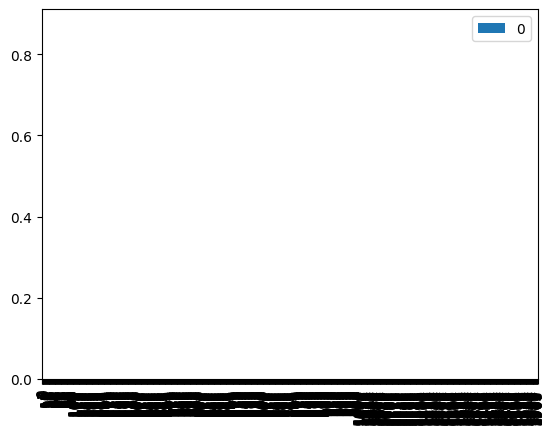

In [106]:
df = pd.DataFrame(p[4])
df.plot.bar()

In [127]:
topic_model._map_probabilities(p[0],True).shape

(1569,)

In [95]:
topic_model.topic_mapper_.get_mappings().keys()

dict_keys([-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 

In [24]:
hierarchical_topics = topic_model.hierarchical_topics(docs)
# Print topic tree
tree = topic_model.get_topic_tree(hierarchical_topics)
print(tree)

100%|██████████| 538/538 [21:43<00:00,  2.42s/it]


.
├─percent_trade_prices_inflation_monetary
│    ├─percent_wage_privatization_trade_tariff
│    │    ├─percent_wage_privatization_trade_pension
│    │    │    ├─monetary policy_monetary_current account_inflation_deficit
│    │    │    │    ├─current account_deficit_monetary policy_imports_inflation
│    │    │    │    │    ├─■──monetary policy_monetary_inflation_policy_target ── Topic: 1
│    │    │    │    │    └─current account_imports_account deficit_account_exports
│    │    │    │    │         ├─current account_imports_account deficit_account_exports
│    │    │    │    │         │    ├─■──real gdp_growth_gdp growth_consumption_growth projected ── Topic: 8
│    │    │    │    │         │    └─■──current account_imports_account deficit_account_exports ── Topic: 4
│    │    │    │    │         └─exchange rate_exchange_rate_foreign exchange_peg
│    │    │    │    │              ├─macroeconomic_inflation_economic_international reserves_economic performance
│    │    │    │    │      

In [10]:
topic_model.visualize_hierarchy(top_n_topics=20)

In [14]:
topic_model.visualize_term_rank()

In [11]:
topic_model.visualize_heatmap(top_n_topics=20)

#### This is going to take a very long time 

In [ ]:

# # Run the visualization with the original embeddings
# topic_model.visualize_documents(docs, embeddings=embeddings)

In [36]:
topic_model.reduce_topics(docs,nr_topics=200)

In [39]:
topic_model.get_topic_freq()

Topic   Count
0       -1  325616
1        0   25081
2        1   18484
3        2   15082
4        3   10724
..     ...     ...
196    195     272
197    196     266
198    197     266
199    198     262
200    199     261

[201 rows x 2 columns]

In [38]:
topic_model.visualize_topics()

In [ ]:
docs = ['''sources estimates projections ''',
'''world data growht gpd debt''']
topics, probs = topic_model.transform(docs)
print(topics,probs)